# FMCW Intro - Target speed

You can open this workbook in Google Colab to experiment with mmWrt 
[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/matt-chv/mmWrt/blob/main/docs/Speed.ipynb)

Below is an intro to mmWrt for simple targets position and speed estimation based on 2D FFT Range Doppler


## The problem

As distance changes over time, how can FMCW radar measure speed ?

## The solution

A 2D FFT will allow to measure the speed of the targets

In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install mmWrt

In [1]:
from os.path import abspath, join, pardir
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from numpy import where, expand_dims

# uncomment below if the notebook is launched from project's root folder
dp = abspath(join(".",pardir))
sys.path.insert(0, dp)


from mmWrt.Raytracing import rt_points  # noqa: E402
from mmWrt.Scene import Radar, Transmitter, Receiver, Target  # noqa: E402
from mmWrt import RadarSignalProcessing as rsp  # noqa: E402

## Step by step

Looking at multiple 1D FFT before doing a 2D FFT

32
(32, 42)


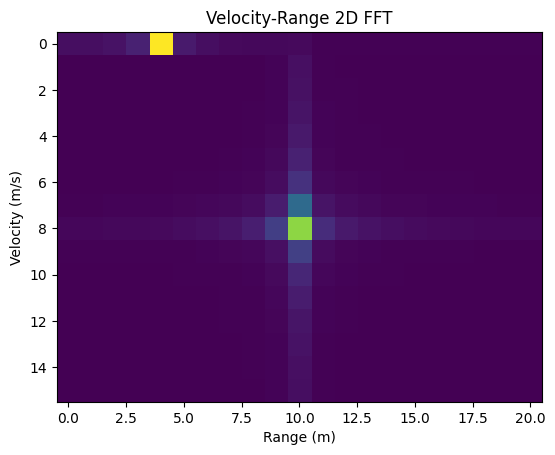

In [15]:
from scipy.fft import fft, fft2
c = 3e8

debug_ON = True
test = 0
NC=32
NA=64
radar = Radar(transmitter=Transmitter(bw=0.3e9, slope=70e8,
                                      t_interchirp=1.2e-6,
                                      chirps_count=NC),
              receiver=Receiver(fs=1e3, max_adc_buffer_size=256,
                                debug=debug_ON), debug=debug_ON)

target1 = Target(2)
target2 = Target(5, 0, 0, vx=lambda t: 500*t+0)

targets = [target1, target2]

bb = rt_points(radar, targets, debug=debug_ON)
print(bb["chirps_count"])
cube = bb["adc_cube"][0,:,0,0,:]
print(cube.shape)
Z_fft2 = abs(fft2(cube))
Data_fft2 = Z_fft2  # [0:n_chirps//2,0:n_samples//2]

plt.xlabel("Range (m)")
plt.ylabel("Velocity (m/s)")
plt.title('Velocity-Range 2D FFT')
plt.imshow(Data_fft2[0:NC//2,0:42//2])


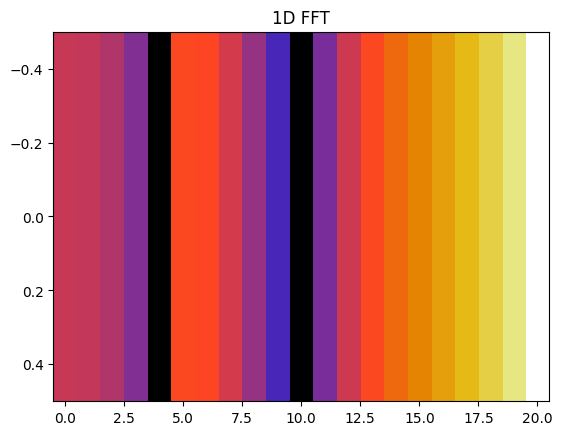

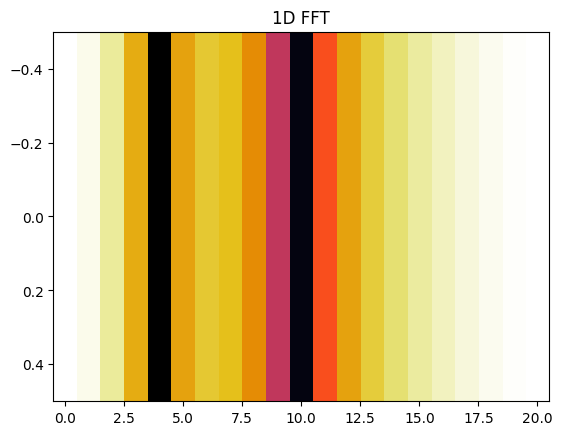

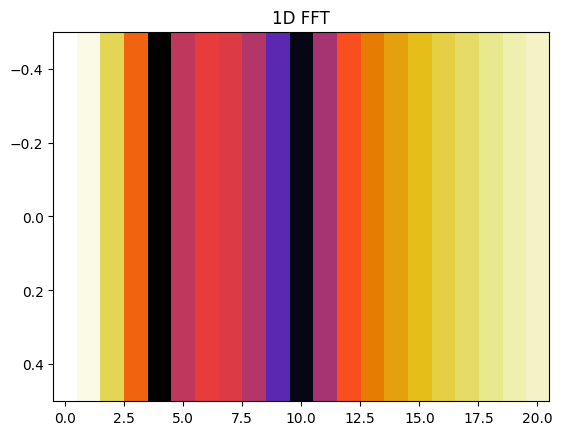

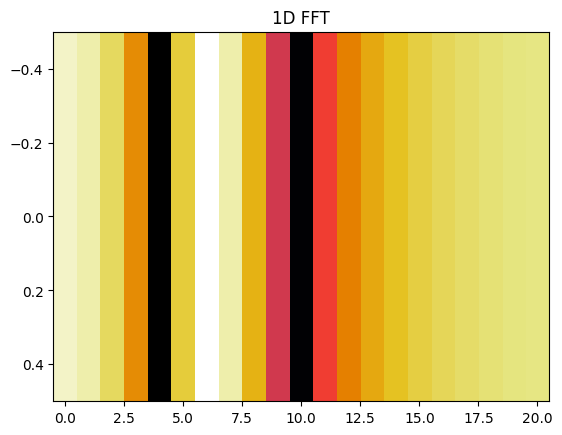

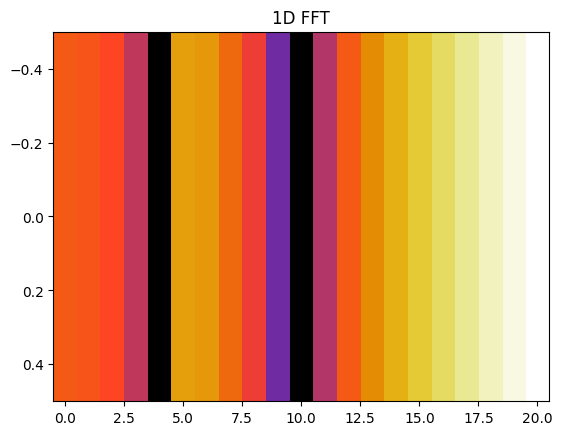

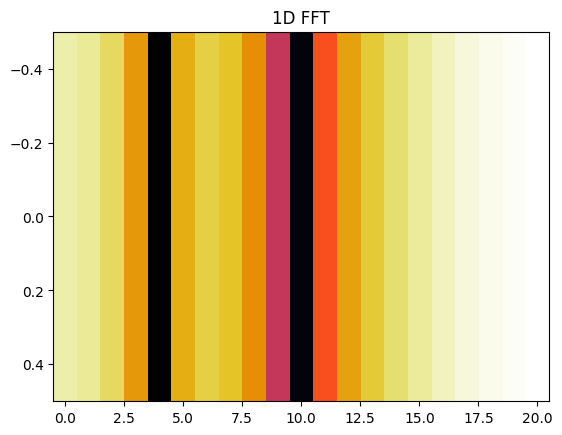

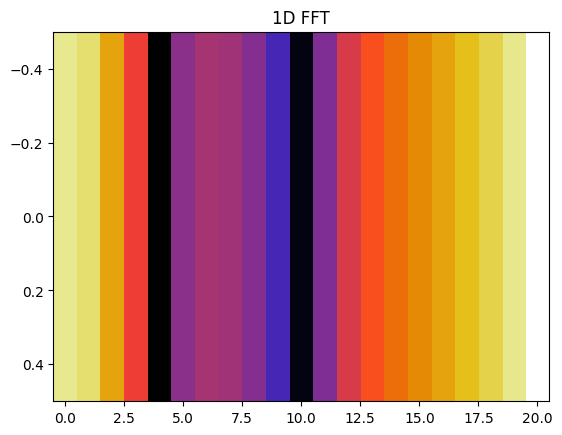

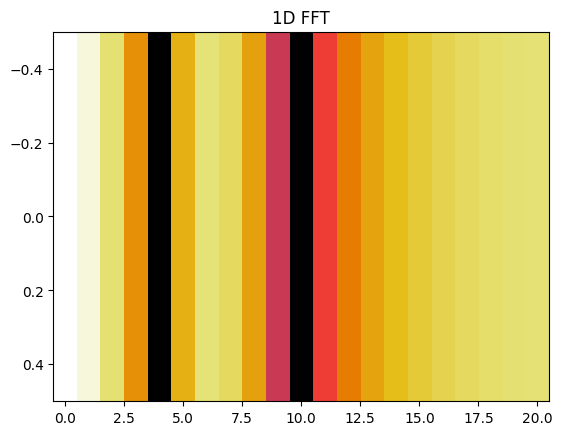

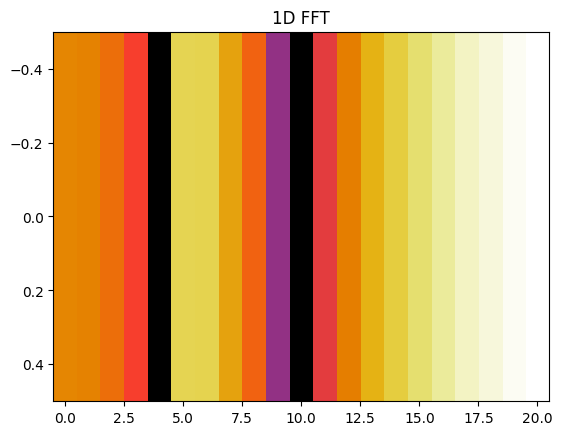

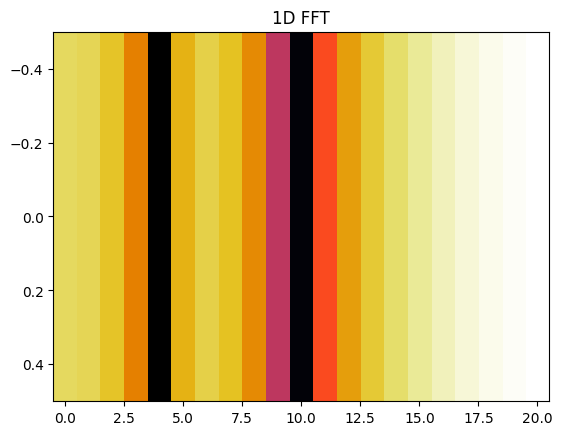

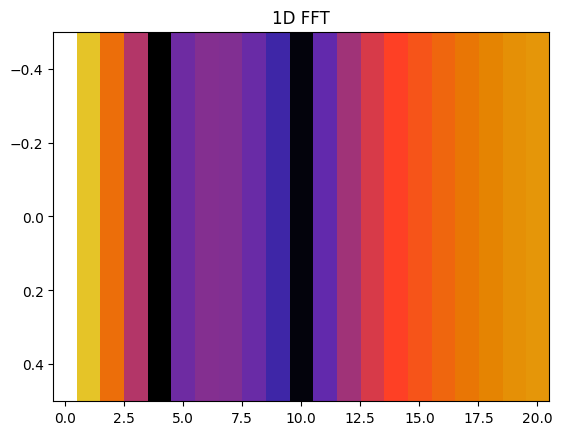

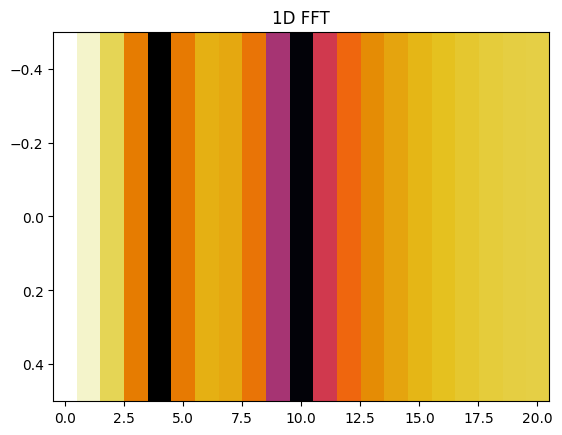

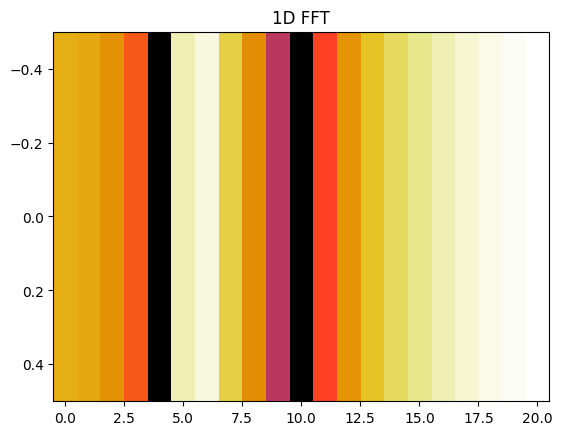

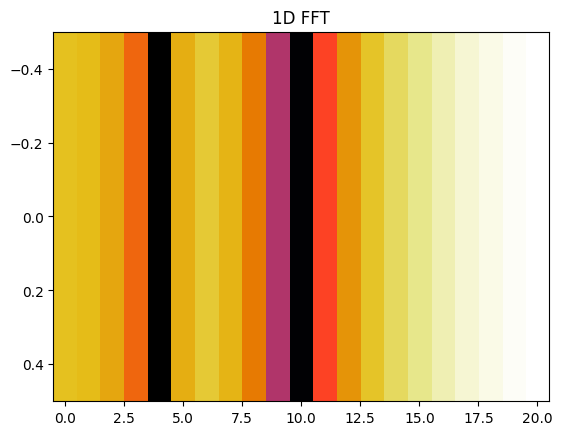

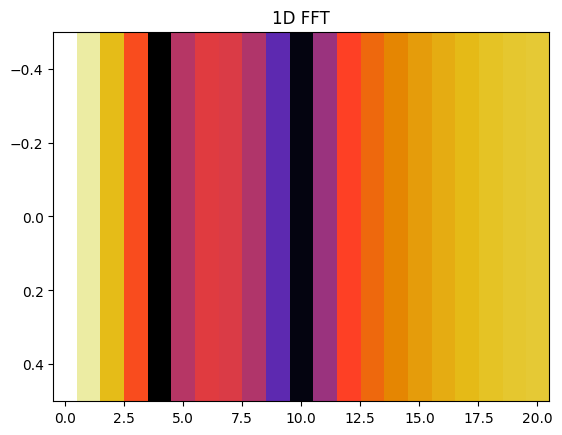

In [32]:
bb = rt_points(radar, targets, debug=debug_ON)
cmap = cm.get_cmap(name='CMRmap_r')
ffts = []
for chirp_i in range(15):
    adc = bb["adc_cube"][0,chirp_i,0,0,:]
    range_profile = fft(adc)

    mag_r = abs(range_profile[:len(range_profile)//2])
    mag_r = expand_dims(mag_r, axis=0)
    plt.imshow(mag_r, cmap,
           aspect='auto',
           norm=colors.LogNorm(vmin=min(mag_r[0][:]), vmax=max(mag_r[0][:])))
    plt.title("1D FFT")
    # plt.savefig(fp_fft_1D)
    plt.show()
    ffts.append(range_profile[:21])

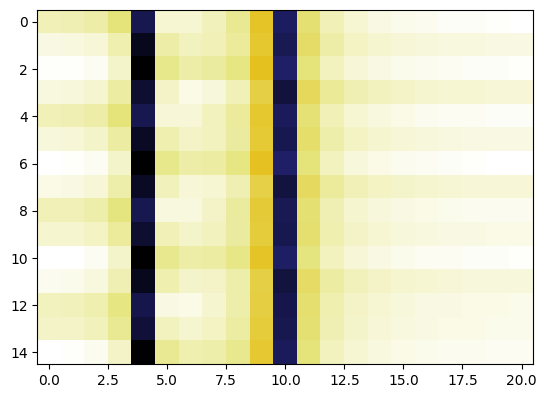

In [37]:
from numpy import array
ffts = array(ffts)
plt.imshow(abs(ffts), cmap=cmap)

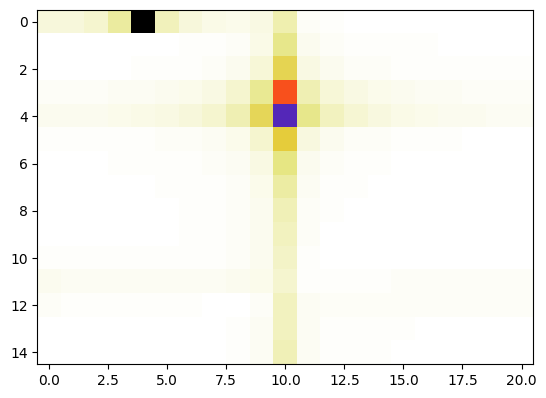

In [40]:
fft2 = fft(ffts, axis=0)
plt.imshow(abs(fft2), cmap=cmap)